## Monte Carlo simulations of Lennard-Jones fluids

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load scientific and plotting libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Load widgets and animation libs 
#from ipywidgets import interact, widgets
#from PIL import Image

# Import random number generators: 
from numpy.random import random
from numpy.random import randint
from numpy.random import uniform
from numpy.random import choice 
from numpy.random import normal

### 0 Where to get random numbers and distributions?: 
 **numpy.random** and **scipy.stats** are the two major  libraries for random numbers and probability distributions in Python.
In particular numpy.random has the fastest random number generators based on low level C code. <br>
https://docs.scipy.org/doc/numpy-1.15.1/reference/routines.random.html <br> 
**Scipy.stats** provides an extensive library of statistical distributions and various tools for statistical analysis (correlation functions, trasnformations, statistical tests etc)  <br> https://docs.scipy.org/doc/scipy/reference/stats.html 
<br>

### Check out LJ fluid properties tabulated by NIST for your reference

https://www.nist.gov/mml/csd/chemical-informatics-research-group/lennard-jones-fluid-properties

In [139]:
# Simulation Parameters
N       = 500
sigma   = 1
epsilon = 1
trunc   = 3*sigma
truncsq = trunc**2
steps   = 100000
T    = 0.85
density = 1.0e-3
L =  (N/density)**(1.0/3.0)

halfL = L/2
sigma6=sigma**6
sigma12=sigma**12

def generateBox(N):
    '''Initialize the simulation box.'''

    particles = []
    for p1 in range(0, N):
        x_coord = uniform(0, L)
        y_coord = uniform(0, L)
        z_coord = uniform(0, L)
        particles.append([x_coord, y_coord, z_coord])
        
    return np.array(particles)

def set_pbc(particle):
    '''Apply perodic boundary conditions.'''

    if particle[0] > L:
        particle[0] -= L
    elif particle[0] < 0:
        particle[0] += L
    if particle[1] > L:
        particle[1] -= L
    elif particle[1] < 0:
        particle[1] += L
    if particle[2] > L:
        particle[2] -= L
    elif particle[2] < 0:
        particle[2] += L
    return particle

def get_distancesq(p1, p2):
    ''' Compute squared distance between two particles p1 and p2 with PBC.'''

    dx = p1[0]-p2[0]
    dy = p1[1]-p2[1]
    dz = p1[2]-p2[2]

    # Peridodic Boundary Conditions (PBC)
    if dx > halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
    if dy > halfL:
        dy -= L
    elif dy < -halfL:
        dy += L
    if dz > halfL:
        dz -= L
    elif dz < -halfL:
        dz += L
    return dx**2+dy**2+dz**2

def getEnergy(particles):
    '''Compute the energy of the system'''
    
    N=len(particles)
    energy = 0
    
    # Compute pair interaction energy between particles with index i and j
    for i in range(0, N-1):
        for j in range(i+1, N):
            dist = get_distancesq(particles[i], particles[j])
            
            if dist <= truncsq:
                energy += 4*epsilon*(sigma12/dist**6)-(sigma6/dist**3)
                
    return energy

def getEnergy_p1(i,pi, particles):
    '''Computes the energy of a single particle.'''   
    energy_pi = 0
    
    for j in range(len(particles)):
        pj=particles[j]
        
        if j != i:    
            dist = get_distancesq(pi,pj)
            
            if dist <= truncsq:
        
                energy_pi += 4*epsilon*(sigma12/dist**6)-(sigma6/dist**3)
        
    return energy_pi


def viz_p(particles):
    '''Some cheap visualization to see where the particles are located''' 
    
    from mpl_toolkits.mplot3d import axes3d
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca(projection='3d')
    
    for pi in particles: 
        ax.scatter(pi[0], pi[1], pi[2], alpha=0.7, c='green', s=30)
    
    ax.set_xlim3d(0,L)
    ax.set_ylim3d(0,L)
    ax.set_zlim3d(0,L)
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$")

#### Visualize box and check particles to make sure everything is okay

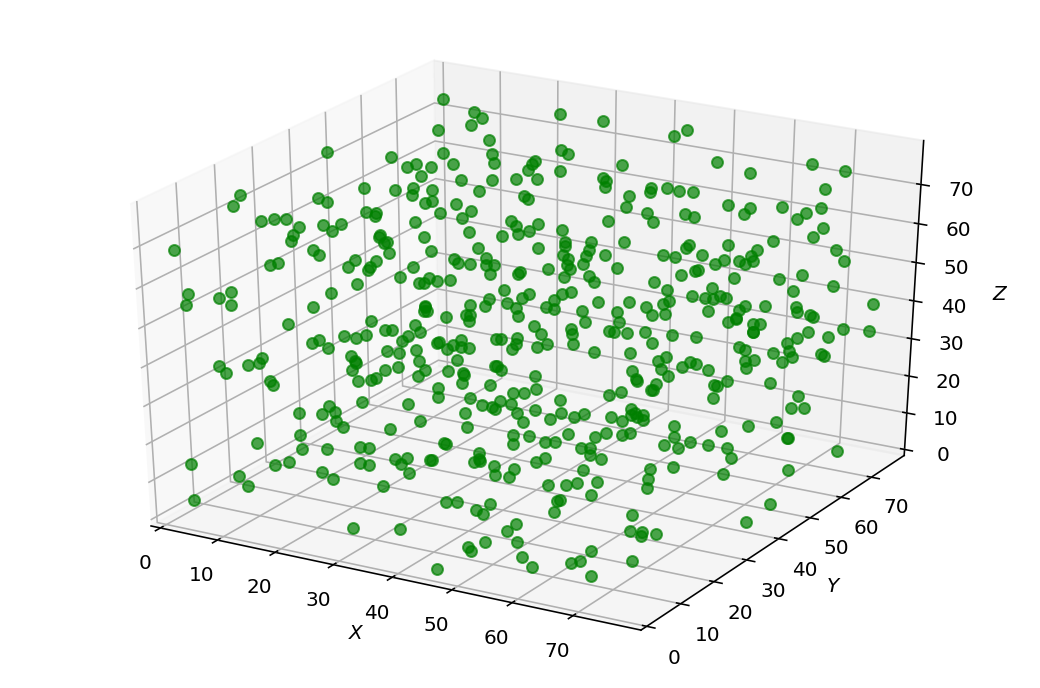

In [143]:
particles=generateBox(N)
viz_p(particles)

In [97]:
particles

array([[18.69714414, 68.58903377, 75.28132656],
       [26.44292233, 27.05121296,  9.07653216],
       [28.49005257, 36.69669324, 10.34895937],
       ...,
       [10.07484681, 13.54183806, 53.86354622],
       [23.39438497, 11.38172461, 47.57337094],
       [22.46384653, 52.47749703,  4.06836797]])

In [98]:
particles[10]

array([48.75874704, 29.96690776, 63.52895909])

#### MC engine for LJ fluid in 3D (NVT ensemble)
Now that the main helper functions are set up we can put together a main Monte Carlo engine that loops through randomly selected particles and attemps their displacement via Metropolis Criterion. 

In [144]:
def doMC_LJ(particles,steps):
    '''Main MC engine'''
    
    # Initialize energies
    en = getEnergy(particles)
    
    # Loop through MC steps moving particles and computing energies
    for step in range(0, steps):
        
        # Randomly choose some particle i 
        i=randint(0, N-1)
    
        #Record energy and location of particle i
        pi = particles[i]
        prev_E = getEnergy_p1(i,pi, particles)
    
        # Give a particle i a random push:
        pi[0] += uniform(-1, 1)
        pi[1] += uniform(-1, 1)
        pi[2] += uniform(-1, 1)
    
        # Apply PBC to fit particle i inside box
        pi = set_pbc(pi)
    
        # Evaluate energy diff
        new_E = getEnergy_p1(i,pi, particles)
        deltaE = new_E - prev_E

        # Metropolis acceptance/rejection conditions
        if deltaE < 0:
            en += deltaE
            particles[i]=pi
    
        elif np.exp(-deltaE/T) > random():
            en += deltaE
            particles[i]=pi
            
        #    writeEnergy()
        #    writeTraj()
            
    return particles

In [145]:
particles=doMC_LJ(particles,1000)

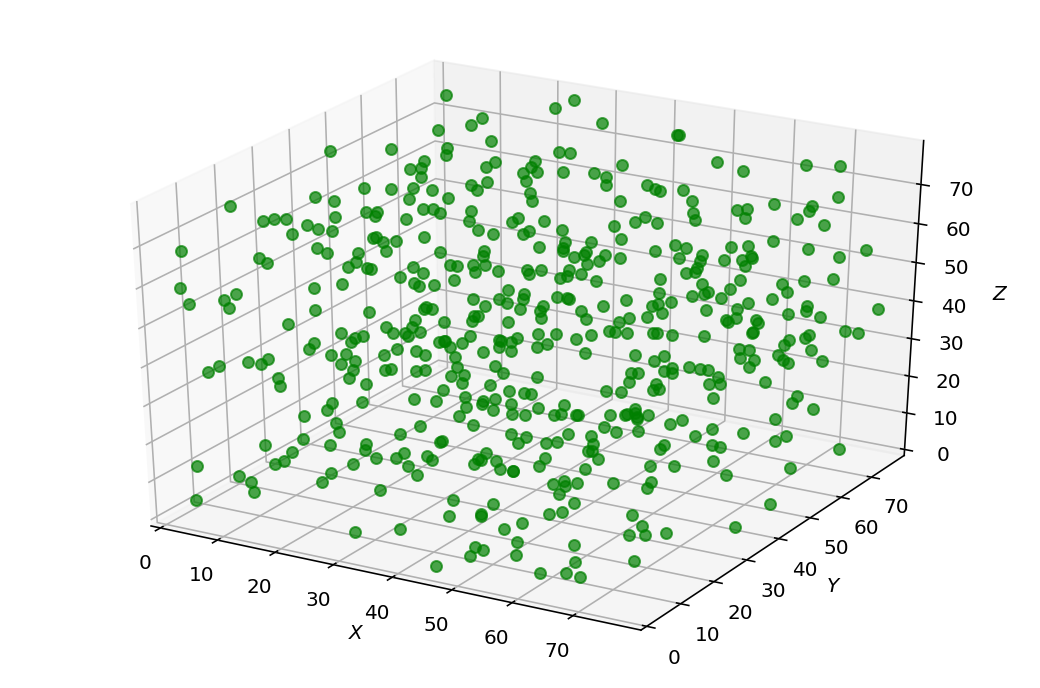

In [146]:
viz_p(particles)

In [135]:
particles=doMC_LJ(particles,1000)

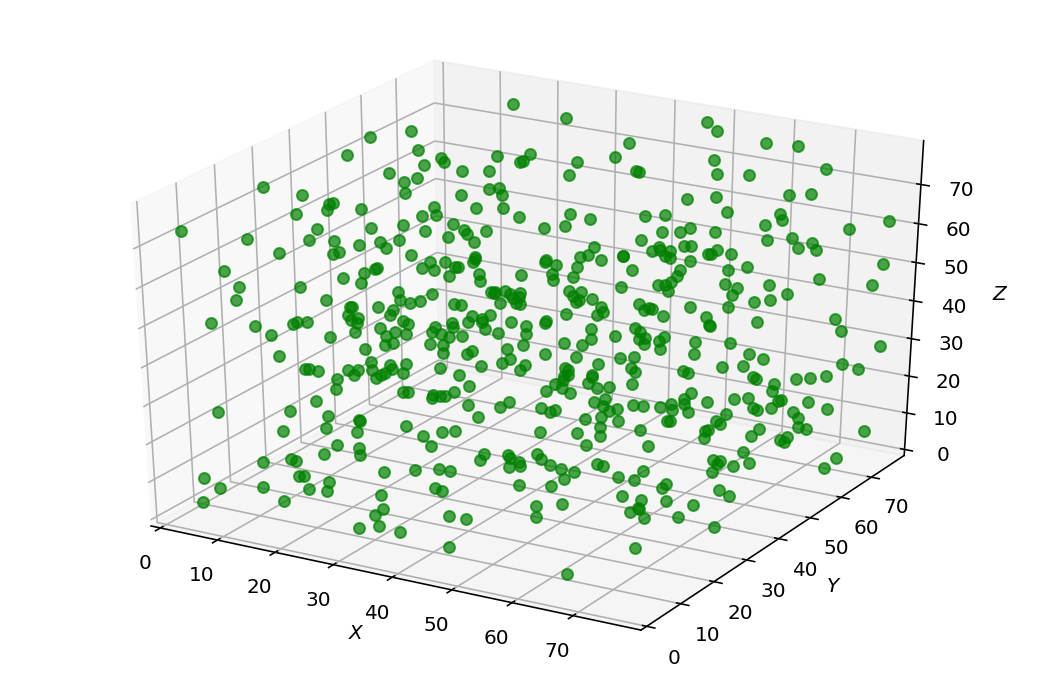

In [136]:
viz_p(particles)

In [4]:
'''Run this cell to render our markdown text with beautiful styles.'''
from IPython.core.display import HTML
def set_css_style(css_file_path):
    styles = open(css_file_path, "r").read()
    return HTML(styles)
set_css_style('./common/custom.css')